In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA 
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


import time
import pickle
import os

%matplotlib inline

In [2]:
#Load the data
df = pd.read_csv('winemag-data_first150k.csv')

#Insert column to flag "Exceptional wines"
df['is_exceptional'] = np.where(df['points']>=90, 1, 0)

#set null prices to the mean price
df.loc[pd.isnull(df.price),'price']=df.price.mean()

#Drop unnamed col
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head(2)
#country, description, designation, points, price, province, region_1, region_2, variety, winery, is_exceptional

,country,description,designation,points,price,province,region_1,region_2,variety,winery,is_exceptional
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1


In [3]:
#avg word function
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))


In [4]:
##Add feaures

#text features
stop = stopwords.words('english')

df['word_count'] = df['description'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['description'].str.len() ## this also includes spaces
df['avg_word'] = df['description'].apply(lambda x: avg_word(x))
df['stopwords'] = df['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['numerics'] = df['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['percent'] = df['description'].apply(lambda x: len([x for x in x.split() if x.endswith('%')]))

#description processing
df['description'] = df['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['description'] = df['description'].str.replace('[^\w\s]','')
df['description'] = df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [5]:
#combine description and designation into 1 column
df['description'] = df['designation'].astype(str) + ' ' + df['winery'] + ' ' + df['description']

#get rid of description so you can get dummies
df_description = df[['description']]
df.drop(['description','designation','winery'], axis=1, inplace=True)
df = pd.get_dummies(df)
df.head(2)

,points,price,is_exceptional,word_count,char_count,avg_word,stopwords,numerics,percent,country_Albania,...,variety_Xynisteri,variety_Yapincak,variety_Zelen,variety_Zibibbo,variety_Zierfandler,variety_Zierfandler-Rotgipfler,variety_Zinfandel,variety_Zlahtina,variety_Zweigelt,variety_Žilavka
0,96,235.0,1,60,355,4.933333,23,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,96,110.0,1,51,318,5.254902,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Create tfidf features
#TF-IDF:  NLP technicque that is intended to reflect how important a word is to the description
#in the collection of all descriptions.  Here, we take the top 1,000 top words
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1))
vect = tfidf.fit_transform(df_description['description'])

columns = tfidf.get_feature_names()

a = vect.toarray()

df2 = pd.DataFrame(np.reshape(a, (len(a),vect.shape[1])),columns=columns)
df = pd.concat([df, df2],axis=1)     

In [7]:
#Definine outcome and predictors.
y = df['is_exceptional']
X = df.loc[:, ~df.columns.isin(['is_exceptional','points'])]

#Definine outcome and predictors with price removed.
y_np = df['is_exceptional']
X_np = df.loc[:, ~df.columns.isin(['is_exceptional','points','price'])]

#Definine outcome and predictors with price removed.
y_points = df['points']
X_points = df.loc[:, ~df.columns.isin(['is_exceptional','points'])]
df.head(2)

,points,price,is_exceptional,word_count,char_count,avg_word,stopwords,numerics,percent,country_Albania,...,years,yeasty,yellow,youll,young,youthful,zest,zesty,zin,zinfandel
0,96,235.0,1,60,355,4.933333,23,0,1,0,...,0.305321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,110.0,1,51,318,5.254902,18,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Create/Load the test and train set
if not os.path.exists('x_train.pkl') & os.path.exists('y_train.pkl') & os.path.exists('x_test.pkl') & os.path.exists('y_test.pkl'):
    # Create training and test sets.
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3)
    
    pickle.dump(X_train, open('x_train.pkl', 'wb'))
    pickle.dump(X_test, open('x_test.pkl', 'wb'))
    pickle.dump(y_train, open('y_train.pkl', 'wb'))
    pickle.dump(y_test, open('y_test.pkl', 'wb'))
else:
    X_train = pickle.load(open('x_train.pkl', 'rb'))
    X_test = pickle.load(open('x_test.pkl', 'rb'))
    y_train = pickle.load(open('y_train.pkl', 'rb'))
    y_test = pickle.load(open('y_test.pkl', 'rb'))

In [ ]:
def run_model(model_name, rf_filename, bool_feature_selection, bool_pca, num_components, clf):
    start_time = time.time()
    
    if not os.path.exists(rf_filename):
        # Initialize and fit the model.
        scaler =  StandardScaler()

        if bool_feature_selection == True & bool_pca == True:
            #Set PCA
            sklearn_pca = PCA(n_components=num_components)
            pipeline = Pipeline([
            ('scale', scaler),
            ('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),
            ('dimensions', sklearn_pca),
            ('classifier', clf)
            ])
        elif bool_feature_selection == True & bool_pca == False:
            #Set PCA
            sklearn_pca = PCA(n_components=num_components)
            pipeline = Pipeline([
            ('scale', scaler),
            ('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),
            ('classifier', clf)
            ])
        elif bool_feature_selection == False & bool_pca == True:
            #Set PCA
            sklearn_pca = PCA(n_components=num_components)
            pipeline = Pipeline([
            ('scale', scaler),
            ('dimensions', sklearn_pca),
            ('classifier', clf)
            ])       
        else:
            pipeline = Pipeline([
            ('scale', scaler),
            ('classifier', clf)
            ])
                
        pipeline.fit(X_train, y_train)
        pickle.dump(pipeline, open(rf_filename, 'wb'))
    else:
        pipeline = pickle.load(open(rf_filename, 'rb'))


    print(model_name)
    print('Training set:')
    print(classification_report(y_train, pipeline.predict(X_train)))
    print('Test set:')
    print(classification_report(y_test, pipeline.predict(X_test)))
    print('Accuracy:  {}'.format(accuracy_score(y_test, pipeline.predict(X_test))))

    print("--- %s seconds ---" % (time.time() - start_time))
    return pipeline

In [ ]:
#Neural Net
#rf_filename = r'neural_net.pkl'
#pipeline = run_model('Neural Network', rf_filename, False, False, 0, MLPClassifier(hidden_layer_sizes=(10,)))

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\classes.py:219: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


In [10]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [12]:
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:


C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:614: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)


             precision    recall  f1-score   support

          0       0.97      0.98      0.97     71916
          1       0.96      0.93      0.94     33735

avg / total       0.96      0.96      0.96    105651

Test set:
             precision    recall  f1-score   support

          0       0.91      0.94      0.92     30804
          1       0.85      0.81      0.83     14475

avg / total       0.89      0.89      0.89     45279

Accuracy:  0.8939905916650103


In [13]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     71916
          1       1.00      0.98      0.99     33735

avg / total       0.99      0.99      0.99    105651

Test set:
             precision    recall  f1-score   support

          0       0.92      0.95      0.94     30804
          1       0.89      0.83      0.86     14475

avg / total       0.91      0.91      0.91     45279

Accuracy:  0.9130501998719053


In [14]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,4,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     71916
          1       1.00      0.89      0.94     33735

avg / total       0.96      0.96      0.96    105651

Test set:
             precision    recall  f1-score   support

          0       0.89      0.96      0.92     30804
          1       0.90      0.74      0.81     14475

avg / total       0.89      0.89      0.89     45279

Accuracy:  0.8915391240972637


In [15]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     71916
          1       1.00      0.99      0.99     33735

avg / total       1.00      1.00      1.00    105651

Test set:
             precision    recall  f1-score   support

          0       0.93      0.96      0.94     30804
          1       0.90      0.84      0.87     14475

avg / total       0.92      0.92      0.92     45279

Accuracy:  0.917666026193158


In [16]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71916
          1       0.99      0.99      0.99     33735

avg / total       0.99      0.99      0.99    105651

Test set:
             precision    recall  f1-score   support

          0       0.94      0.94      0.94     30804
          1       0.87      0.87      0.87     14475

avg / total       0.92      0.92      0.92     45279

Accuracy:  0.9166942732834206


In [17]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     71916
          1       0.97      0.99      0.98     33735

avg / total       0.99      0.99      0.99    105651

Test set:
             precision    recall  f1-score   support

          0       0.94      0.92      0.93     30804
          1       0.84      0.88      0.86     14475

avg / total       0.91      0.91      0.91     45279

Accuracy:  0.9078380706287683


In [9]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       0.98      0.97      0.98     71916
          1       0.94      0.96      0.95     33735

avg / total       0.97      0.97      0.97    105651

Test set:
             precision    recall  f1-score   support

          0       0.94      0.92      0.93     30804
          1       0.84      0.87      0.86     14475

avg / total       0.91      0.91      0.91     45279

Accuracy:  0.9067779765454184


In [12]:
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


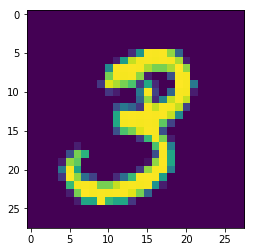

In [13]:
plt.figure()
plt.imshow(mnist.train.images[1, :].reshape(28, 28))

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [15]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(mnist.train.images, mnist.train.labels)
print(classification_report(mnist.test.labels, rfc.predict(mnist.test.images)))

             precision    recall  f1-score   support

          0       0.99      0.94      0.97       980
          1       1.00      0.97      0.98      1135
          2       0.99      0.86      0.92      1032
          3       0.99      0.81      0.89      1010
          4       0.99      0.85      0.92       982
          5       1.00      0.79      0.88       892
          6       0.99      0.89      0.94       958
          7       0.99      0.88      0.93      1028
          8       0.99      0.77      0.87       974
          9       0.98      0.85      0.91      1009

avg / total       0.99      0.86      0.92     10000



In [16]:
X_train = mnist.train.images
y_train = mnist.train.labels

X_test = mnist.test.images
y_test = mnist.test.labels

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

Training set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5444
          1       1.00      1.00      1.00      6179
          2       1.00      1.00      1.00      5470
          3       1.00      1.00      1.00      5638
          4       1.00      1.00      1.00      5307
          5       1.00      0.99      1.00      4987
          6       1.00      1.00      1.00      5417
          7       1.00      1.00      1.00      5715
          8       1.00      1.00      1.00      5389
          9       1.00      1.00      1.00      5454

avg / total       1.00      1.00      1.00     55000

Test set:
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.96      0.97      1032
          3       0.97      0.97      0.97      1010
          4       0.98      0.97      0.97       982
          5       

In [17]:
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,16,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train, y_train)
print('Training set:')
print(classification_report(y_train, mlp.predict(X_train)))
print('Test set:')
print(classification_report(y_test, mlp.predict(X_test)))
print('Accuracy:  {}'.format(accuracy_score(y_test, mlp.predict(X_test))))

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set:
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      5444
          1       0.99      0.99      0.99      6179
          2       0.98      0.97      0.98      5470
          3       0.98      0.97      0.97      5638
          4       0.98      0.97      0.98      5307
          5       0.99      0.97      0.98      4987
          6       0.99      0.98      0.99      5417
          7       0.98      0.98      0.98      5715
          8       0.98      0.97      0.98      5389
          9       0.98      0.97      0.98      5454

avg / total       0.99      0.98      0.98     55000

Test set:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.98      0.98      0.98      1135
          2       0.96      0.94      0.95      1032
          3       0.92      0.94      0.93      1010
          4       0.96      0.94      0.95       982
          5       